# ML Training

This notebook covers the model training process of this project

In this notebook, we:

1. Load in our dataset with features,
    * Address dataset imbalance usine MLSMOTE (SMOTE adapted for multilabel classification)
2. Run hyperparameter tuning via RandomSearchCV
    * RandomSearchCV faster/less resource-intensive than GridSearchCV
3. Train model on 'optimal' hyperparameter set
4. Evaluate using recall
    * Recall more suited for our usecase as we want to limit number of false negatives (failures that get missed)
5. Adjust decision threshold accordingly


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, recall_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

feature_target_table = pd.read_csv('data/feature_table.csv')
failures = pd.read_csv('data/PdM_failures.csv')
components = failures['failure'].unique()
# Define features and target variables
features = [col for col in feature_target_table.columns if col not in ['datetime', 'machineID', 'model'] + [f'failure_{comp}_next_24h' for comp in components] + ['no_failure_next_24h']]
targets = [f'failure_{comp}_next_24h' for comp in components] + ['no_failure_next_24h']


### Dataset Imbalance

We can see that there is a big difference in dataset size. When initially running the model, a confusion matrix made it obvious that we were mostly labelling things the majority class (no failure), which can easily mislead us to a high accuracy. In reality, it would mislabel failures as a non-failure.

To address this, we can adjust weights or use data sampling methods like SMOTE.

In [2]:
dataset_size = len(feature_target_table[targets])
failure_counts = feature_target_table[targets].sum()
print(f'Data size: {dataset_size}\n')
print(f'Failures: \n{failure_counts}\n')
print(f'Non-failures: \n{dataset_size - failure_counts}')


Data size: 875000

Failures: 
failure_comp4_next_24h      4254
failure_comp1_next_24h      4460
failure_comp2_next_24h      6174
failure_comp3_next_24h      3091
no_failure_next_24h       858025
dtype: int64

Non-failures: 
failure_comp4_next_24h    870746
failure_comp1_next_24h    870540
failure_comp2_next_24h    868826
failure_comp3_next_24h    871909
no_failure_next_24h        16975
dtype: int64


In [8]:
# Split the data into training and testing sets
X = feature_target_table[features]
y = feature_target_table[targets]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from mlsmote import create_dataset, get_minority_instace, MLSMOTE

# X_sub, y_sub = get_minority_instace(X, y) 

# X_res, y_res = MLSMOTE(X_sub, y_sub, 300000)

# X_sm = pd.concat([X, X_res], axis=0)
# y_sm = pd.concat([y, y_res], axis=0)
# X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

######### Use MLSMOTE on training data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_sub, y_sub = get_minority_instace(X_train, y_train) 
X_res, y_res = MLSMOTE(X_sub, y_sub, 800000)

X_train_res = pd.concat([X_train, X_res], axis=0)
y_train_res = pd.concat([y_train, y_res], axis=0)

# Apply SMOTE to each target variable separately and concatenate the results
# X_train_resampled = []
# y_train_resampled = []

# for target in targets:
#     sm = SMOTE(random_state=42)
#     X_res, y_res = sm.fit_resample(X_train, y_train[target])
#     X_train_resampled.append(X_res)
#     y_train_resampled.append(y_res)

# X_train_res = []
# y_train_res = pd.DataFrame()

# for target in targets:
#     smote = SMOTE(random_state=42)
#     X_res, y_res = smote.fit_resample(X_train, y_train[target])
#     X_train_res.append(X_res)
#     y_train_res[target] = y_res

# Ensure the resampled features match the shape
# X_train_res = pd.concat(X_train_res, axis=0)
# y_train_res = y_train_res.loc[X_train_res.index]

In [4]:
X_train.columns

Index(['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_lag1',
       'volt_lag2', 'volt_lag3', 'rotate_lag1', 'rotate_lag2', 'rotate_lag3',
       'pressure_lag1', 'pressure_lag2', 'pressure_lag3', 'vibration_lag1',
       'vibration_lag2', 'vibration_lag3', 'volt_roll_mean_6',
       'volt_roll_mean_12', 'rotate_roll_mean_6', 'rotate_roll_mean_12',
       'pressure_roll_mean_6', 'pressure_roll_mean_12',
       'vibration_roll_mean_6', 'vibration_roll_mean_12', 'error1_count_6h',
       'error1_count_12h', 'error3_count_6h', 'error3_count_12h',
       'error5_count_6h', 'error5_count_12h', 'error4_count_6h',
       'error4_count_12h', 'error2_count_6h', 'error2_count_12h',
       'model_number'],
      dtype='object')

In [9]:
y_train.sum()

failure_comp4_next_24h      3394
failure_comp1_next_24h      3573
failure_comp2_next_24h      4946
failure_comp3_next_24h      2464
no_failure_next_24h       686401
dtype: int64

In [10]:
y_train_res.sum()

failure_comp4_next_24h    283370.0
failure_comp1_next_24h    313571.0
failure_comp2_next_24h     52913.0
failure_comp3_next_24h    226145.0
no_failure_next_24h       686401.0
dtype: float64

In [11]:
y_res.sum()

failure_comp4_next_24h    279976.0
failure_comp1_next_24h    309998.0
failure_comp2_next_24h     47967.0
failure_comp3_next_24h    223681.0
no_failure_next_24h            0.0
dtype: float64

In [12]:
y_sub.sum()

failure_comp4_next_24h    3394
failure_comp1_next_24h    3573
failure_comp2_next_24h     504
failure_comp3_next_24h    2464
no_failure_next_24h          0
dtype: int64

# Model Training & Evaluation

### Training

In [ ]:
"""from sklearn.model_selection import RandomizedSearchCV
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,500,1000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl, param_distributions=prams, verbose=10, n_jobs=-1,)
random_cfl.fit(X_train_res, y_train_res)"""

"from sklearn.model_selection import RandomizedSearchCV\nx_cfl=XGBClassifier()\n\nprams={\n    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],\n     'n_estimators':[100,500,1000],\n     'max_depth':[3,5,10],\n    'colsample_bytree':[0.1,0.3,0.5,1],\n    'subsample':[0.1,0.3,0.5,1]\n}\nrandom_cfl=RandomizedSearchCV(x_cfl, param_distributions=prams, verbose=10, n_jobs=-1,)\nrandom_cfl.fit(X_train_res, y_train_res)"

In [ ]:
print(random_cfl.best_params_)

{'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.1}


In [13]:
# Define and train the model
# model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
# model.fit(X_train, y_train)

# Define and train the XGBoost model with balanced class weights
xgb_clf = XGBClassifier(scale_pos_weight=5, use_label_encoder=False, eval_metric='logloss', random_state=42,n_estimators=1000, learning_rate=0.2, colsample_bytree=0.1, max_depth=10,subsample=1)
model = MultiOutputClassifier(xgb_clf)
model.fit(X_train_res, y_train_res)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
# Evaluate the model
for i, target in enumerate(targets):
    print(f'Classification Report for {target}:')
    print(classification_report(y_test[target], y_pred[:, i]))

# Example of overall evaluation
from sklearn.metrics import accuracy_score, hamming_loss

accuracy = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f'Overall Accuracy: {accuracy}')
print(f'Hamming Loss: {hamming}')

Classification Report for failure_comp4_next_24h:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    174140
           1       0.66      0.57      0.61       860

    accuracy                           1.00    175000
   macro avg       0.83      0.79      0.81    175000
weighted avg       1.00      1.00      1.00    175000

Classification Report for failure_comp1_next_24h:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    174113
           1       0.67      0.49      0.57       887

    accuracy                           1.00    175000
   macro avg       0.83      0.75      0.78    175000
weighted avg       1.00      1.00      1.00    175000

Classification Report for failure_comp2_next_24h:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    173772
           1       0.90      0.54      0.67      1228

    accuracy                    

In [20]:
y_test.sum()

failure_comp4_next_24h       860
failure_comp1_next_24h       887
failure_comp2_next_24h      1228
failure_comp3_next_24h       627
no_failure_next_24h       171624
dtype: int64

### Evaluation

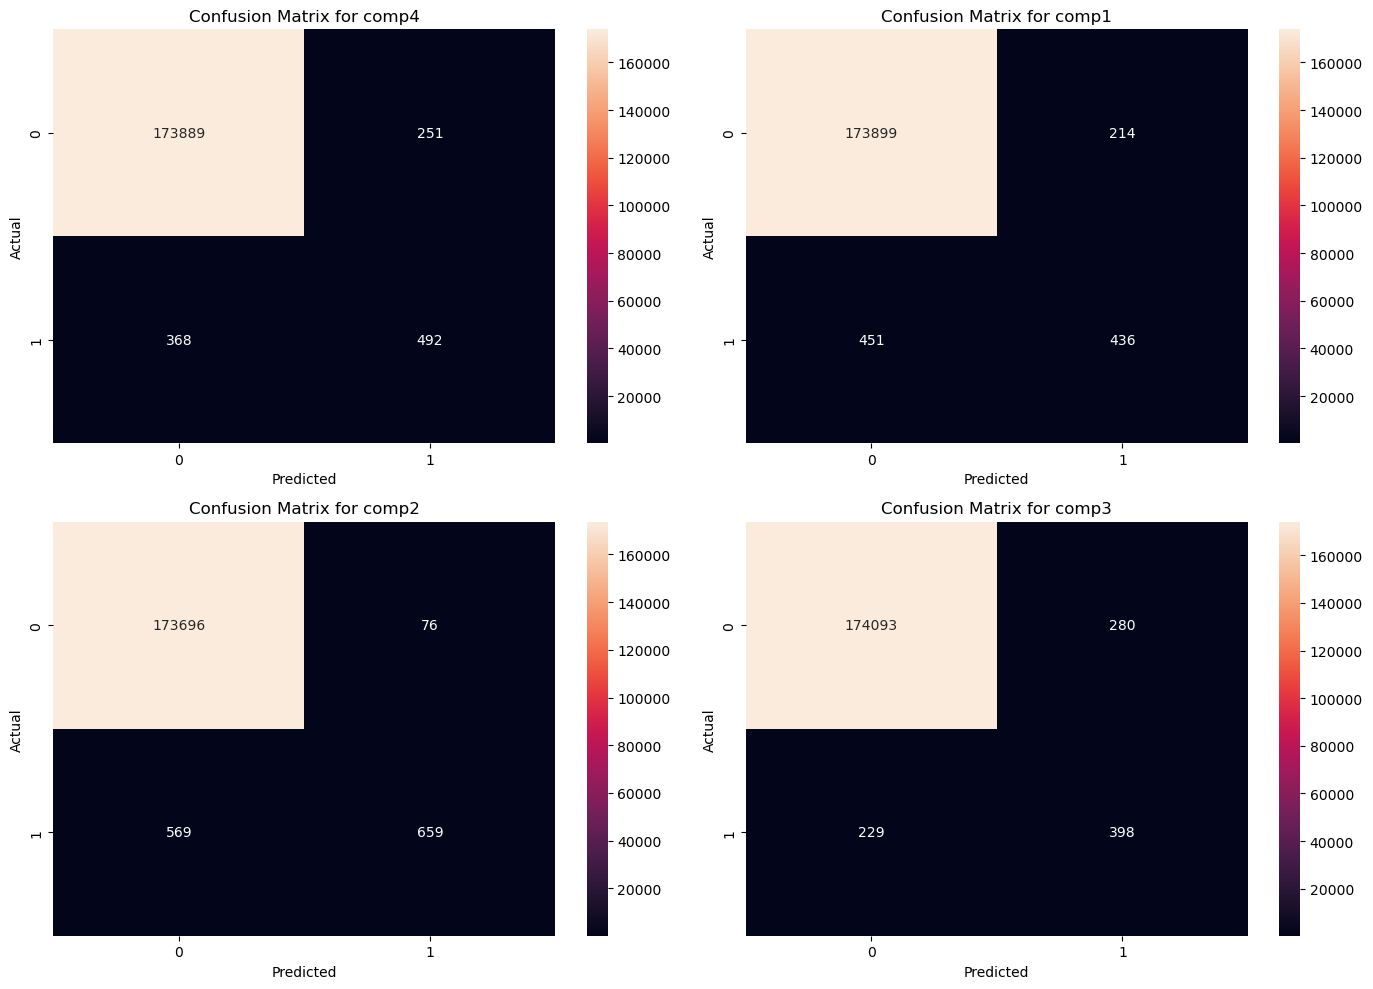

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()
for i, component in enumerate(components):
    cm = confusion_matrix(y_test[targets[i]], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {component}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


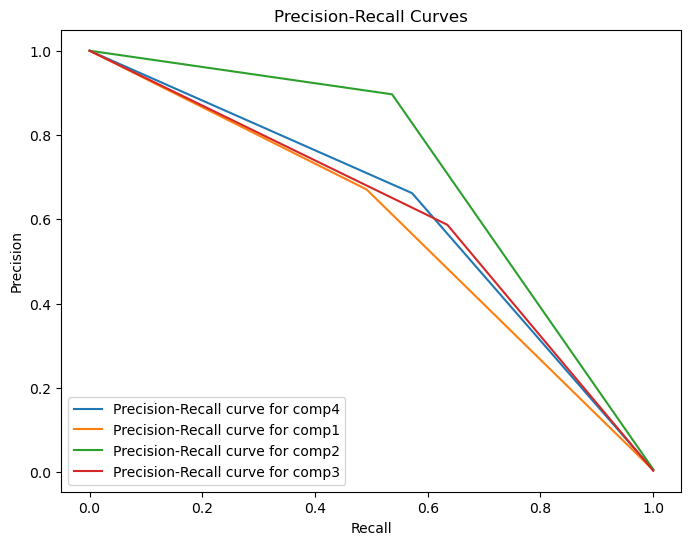

In [72]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
for i, component in enumerate(components):
    precision, recall, _ = precision_recall_curve(y_test[targets[i]], y_pred[:, i])
    plt.plot(recall, precision, label=f'Precision-Recall curve for {component}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()


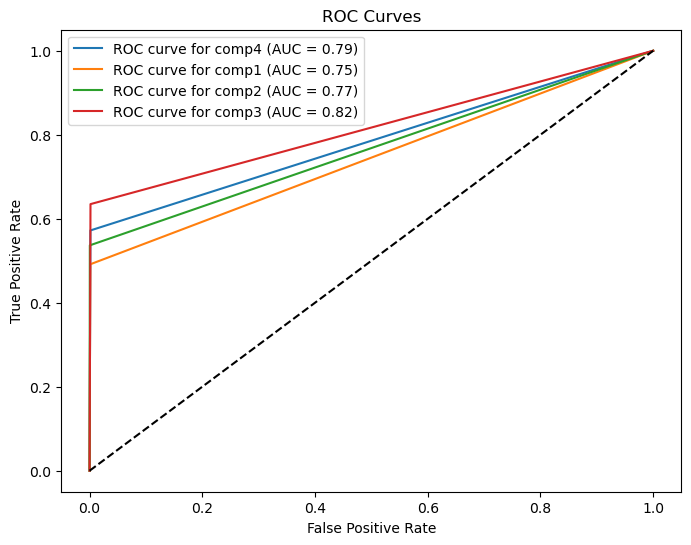

In [70]:
# ROC Curve
plt.figure(figsize=(8, 6))
for i, component in enumerate(components):
    fpr, tpr, _ = roc_curve(y_test[targets[i]], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {component} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

### Threshold tuning

In [64]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
y_proba = model.predict_proba(X_test)
avg_recalls = []
avg_target_recalls = []
for t in thresholds:
    y_pred_thresh = np.zeros_like(y_test.values)
    for i in range(len(targets)):
        y_pred_thresh[:, i] = (y_proba[i][:, 1] >= t).astype(int)

    # Compute recall for each target and average it
    recalls = [recall_score(y_test[target], y_pred_thresh[:, i]) for i, target in enumerate(targets)]
    avg_recall = np.mean(recalls)
    avg_recalls.append(avg_recall)
    avg_target_recalls.append(recalls)
    for i, target in enumerate(targets):
        print(f'Classification Report for {target} (threshold={t}):')
        print(classification_report(y_test[target], y_pred_thresh[:, i]))
    print(f"Threshold: {t:.2f} | Avg Recall: {avg_recall:.4f} | Per Target Recall: {[f'{r:.2f}' for r in recalls]}")


Classification Report for failure_comp4_next_24h (threshold=0.1):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    174140
           1       0.33      0.78      0.47       860

    accuracy                           0.99    175000
   macro avg       0.67      0.89      0.73    175000
weighted avg       1.00      0.99      0.99    175000

Classification Report for failure_comp1_next_24h (threshold=0.1):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    174113
           1       0.30      0.64      0.41       887

    accuracy                           0.99    175000
   macro avg       0.65      0.82      0.70    175000
weighted avg       0.99      0.99      0.99    175000

Classification Report for failure_comp2_next_24h (threshold=0.1):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    173772
           1       0.57      0.64      

In [65]:
for i, t in enumerate(thresholds):
    print(f"Threshold: {t:.2f} | Avg Recall: {avg_recalls[i]:.4f} | Per Target Recall (comp4, comp1, comp2, comp3, nofail): {[f'{r:.2f}' for r in avg_target_recalls[i]]}")


Threshold: 0.10 | Avg Recall: 0.7722 | Per Target Recall (comp4, comp1, comp2, comp3, nofail): ['0.78', '0.64', '0.64', '0.80', '1.00']
Threshold: 0.20 | Avg Recall: 0.7119 | Per Target Recall (comp4, comp1, comp2, comp3, nofail): ['0.67', '0.56', '0.58', '0.75', '1.00']
Threshold: 0.30 | Avg Recall: 0.6813 | Per Target Recall (comp4, comp1, comp2, comp3, nofail): ['0.62', '0.53', '0.56', '0.70', '1.00']
Threshold: 0.40 | Avg Recall: 0.6663 | Per Target Recall (comp4, comp1, comp2, comp3, nofail): ['0.60', '0.51', '0.55', '0.67', '1.00']
Threshold: 0.50 | Avg Recall: 0.6468 | Per Target Recall (comp4, comp1, comp2, comp3, nofail): ['0.57', '0.49', '0.54', '0.63', '1.00']


In [56]:
avg_recalls

[]

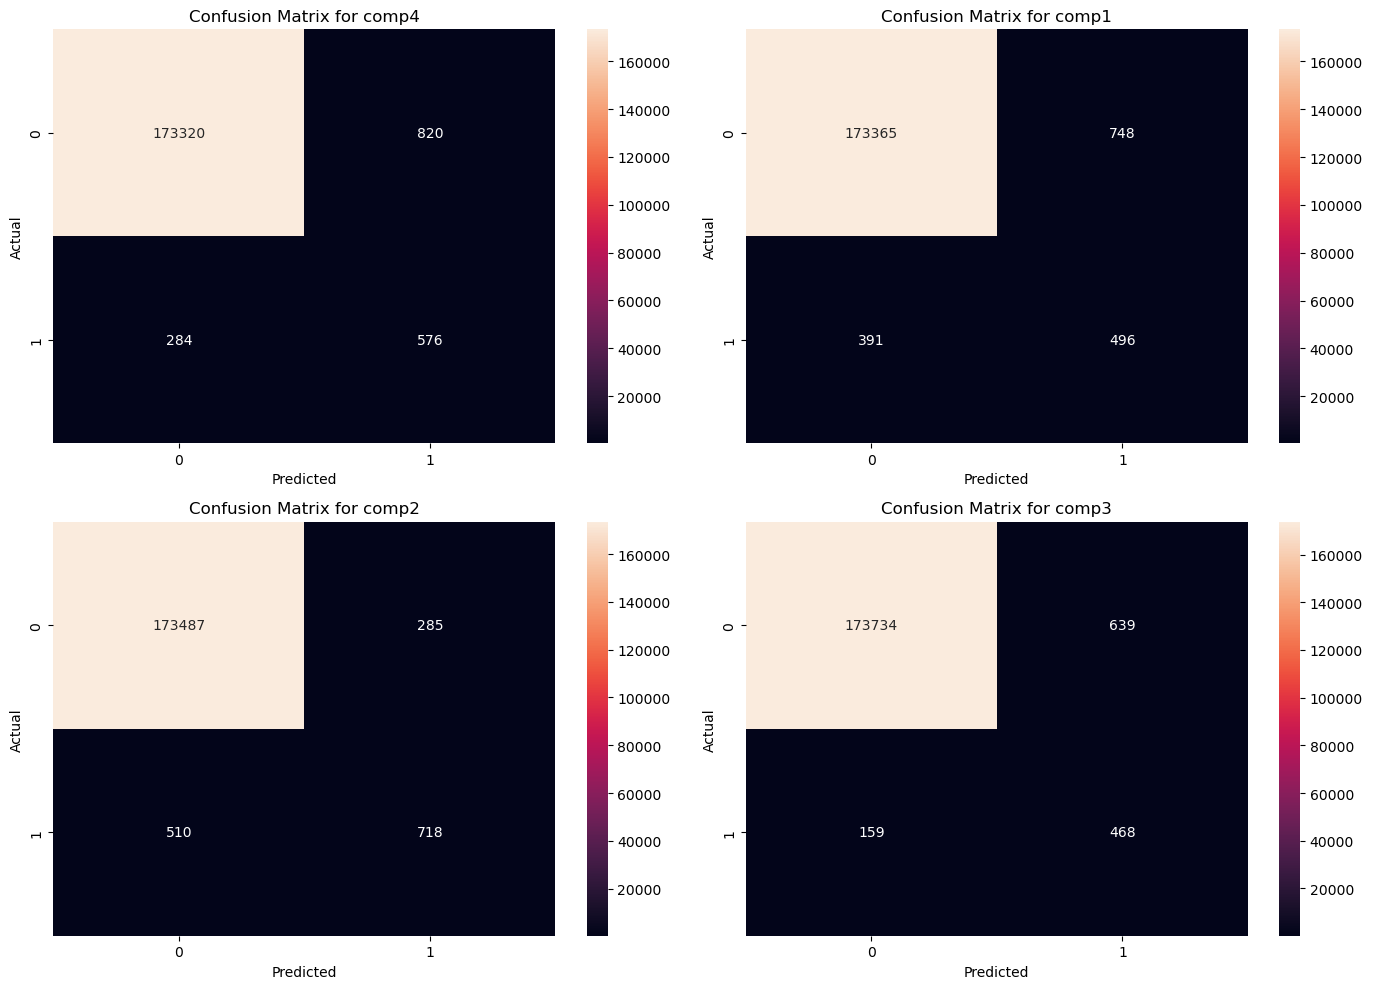

In [73]:
threshold = 0.2
for i in range(len(targets)):
    y_pred_thresh[:, i] = (y_proba[i][:, 1] >= threshold).astype(int)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()
for i, component in enumerate(components):
    cm = confusion_matrix(y_test[targets[i]], y_pred_thresh[:, i])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {component}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()
